In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

test_data_id = test_data.PassengerId

In [2]:
print(train_data.shape,test_data.shape)

(891, 12) (418, 11)


In [3]:
print(train_data.isnull().sum(),'\n\n',test_data.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64 

 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [4]:
train_data.columns[train_data.dtypes!=object].tolist()

['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [5]:
train_data.columns[train_data.dtypes==object].tolist()

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

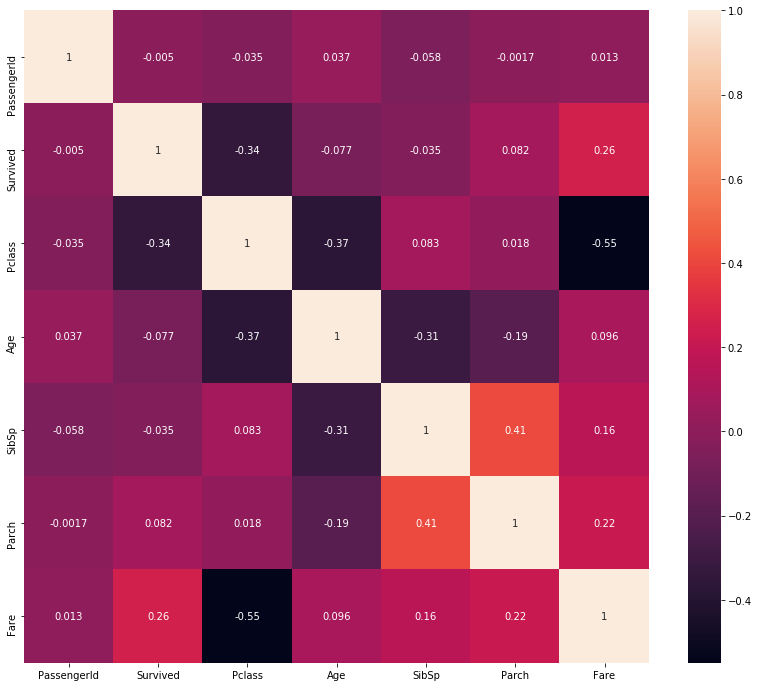

In [6]:
f, ax = plt.subplots(figsize=(14,12))
sns.heatmap(train_data.corr(), annot=True)

In [7]:
combined = [train_data,test_data]
# 对于训练集和测试集，都要一起进行数据处理

In [8]:
[ds.drop(labels='Ticket', inplace=True, axis=1) for ds in combined]
[ds.drop(labels='PassengerId', inplace=True, axis=1) for ds in combined]
# [ds.drop(labels='Cabin', inplace=True, axis=1) for ds in combined]

[None, None]

In [9]:
[ds.Embarked.fillna(ds.Embarked.mode()[0],inplace=True)for ds in combined]

[None, None]

In [10]:
train_data['Cabin'], test_data['Cabin'] = [[1 if x != 0 else 0 for x in ds['Cabin'].fillna(0)] for ds in combined]
combined = [train_data, test_data] # Same as before, we update combined

In [11]:
train_data['Title'], test_data['Title'] = [ds['Name'].str.extract(' ([A-Za-z]+)\.', expand=False) for ds in combined]
combined = [train_data, test_data]

[ds['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Ms'], 
                     'Other', inplace=True) for ds in combined]
[ds['Title'].replace(['Mme','Mlle','Dona'], 'Miss', inplace=True) for ds in combined]

[ds.drop(labels='Name', inplace=True, axis=1) for ds in combined]

[None, None]

In [12]:
train_data.groupby('Title')['Age'].mean()

Title
Master     4.574167
Miss      21.818792
Mr        32.368090
Mrs       35.898148
Other     44.782609
Name: Age, dtype: float64

In [13]:
# 对缺失值进行填补
train_data.loc[(train_data.Age.isnull())&(train_data.Title=='Master'),'Age']=4.5
train_data.loc[(train_data.Age.isnull())&(train_data.Title=='Mr'),'Age']=32.3
train_data.loc[(train_data.Age.isnull())&(train_data.Title=='Miss'),'Age']=21.8
train_data.loc[(train_data.Age.isnull())&(train_data.Title=='Mrs'),'Age']=35.8
train_data.loc[(train_data.Age.isnull())&(train_data.Title=='Other'),'Age']=44.7

test_data.loc[(test_data.Age.isnull())&(test_data.Title=='Master'),'Age']=4.5
test_data.loc[(test_data.Age.isnull())&(test_data.Title=='Mr'),'Age']=32.3
test_data.loc[(test_data.Age.isnull())&(test_data.Title=='Miss'),'Age']=21.8
test_data.loc[(test_data.Age.isnull())&(test_data.Title=='Mrs'),'Age']=35.8
test_data.loc[(test_data.Age.isnull())&(test_data.Title=='Other'),'Age']=44.7
#查看是否都填补好了
train_data.Age.isnull().any()

False

In [14]:
train_data['AgeBand'], test_data['AgeBand'] = [pd.cut(ds['Age'], bins=[0,20,45,60,120], labels=[1,2,3,4]) for ds in combined]
combined = [train_data, test_data]

[ds.drop(labels='Age', inplace=True, axis=1) for ds in combined]

[None, None]

In [15]:
train_data['FamilySize'], test_data['FamilySize'] = [ds['SibSp'] + ds['Parch'] +1 for ds in combined]
[ds.drop(['SibSp', 'Parch'], axis=1, inplace=True) for ds in combined]

[None, None]

In [16]:
[ds.Fare.fillna(ds['Fare'].median(), inplace=True) for ds in combined]

train_data['FareBand'], test_data['FareBand'] =[pd.cut(ds['Fare'], bins=5,labels=[1,2,3,4,5]) for ds in combined]

[ds.drop(['Fare'], axis=1, inplace=True) for ds in combined]

[None, None]

In [17]:
# One hot encoding these variables:
train_data, test_data = [pd.get_dummies(ds, columns=['Sex', 'Embarked','Pclass','Title']) for ds in combined]
combined = [train_data, test_data] # Dummies changes have been done in train and test, we must update combined
train_data.sample(5)

,Survived,Cabin,AgeBand,FamilySize,FareBand,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other
687,0,0,1,1,1,0,1,0,0,1,0,0,1,0,0,1,0,0
738,0,0,2,1,1,0,1,0,0,1,0,0,1,0,0,1,0,0
802,1,1,1,4,2,0,1,0,0,1,1,0,0,1,0,0,0,0
584,0,0,2,1,1,0,1,1,0,0,0,0,1,0,0,1,0,0
299,1,1,3,2,3,1,0,1,0,0,1,0,0,0,0,0,1,0


In [18]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel='rbf', C=0.025, probability=True),
    NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    MLPClassifier()
    ]

log_cols = ['Classifier', 'Accuracy', 'Log Loss']
log = pd.DataFrame(columns=log_cols)

from sklearn.model_selection import train_test_split

X = train_data.drop(['Survived'], axis=1)
y = train_data['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)

In [19]:
for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print('='*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print('Accuracy: {:.4%}'.format(acc))
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print('Log Loss {}:'.format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
    print('='*30)

KNeighborsClassifier
****Results****
Accuracy: 79.8206%
Log Loss 2.7628092247640494:
SVC
****Results****
Accuracy: 76.6816%
Log Loss 0.4550902658822985:
NuSVC
****Results****
Accuracy: 82.5112%
Log Loss 0.45639753928731147:
DecisionTreeClassifier
****Results****
Accuracy: 79.3722%
Log Loss 3.0531302518930508:
RandomForestClassifier
****Results****
Accuracy: 80.7175%
Log Loss 0.47897310913932956:
AdaBoostClassifier
****Results****
Accuracy: 79.3722%
Log Loss 0.674377676196395:
GradientBoostingClassifier
****Results****
Accuracy: 81.6143%
Log Loss 0.45338810380869615:
GaussianNB
****Results****
Accuracy: 82.0628%
Log Loss 1.1090609093712966:
LinearDiscriminantAnalysis
****Results****
Accuracy: 82.5112%
Log Loss 0.452287898337526:
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 75.7848%
Log Loss 6.499279807438285:


D:\anaconda\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


MLPClassifier
****Results****
Accuracy: 80.7175%
Log Loss 0.44640594640368647:


D:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


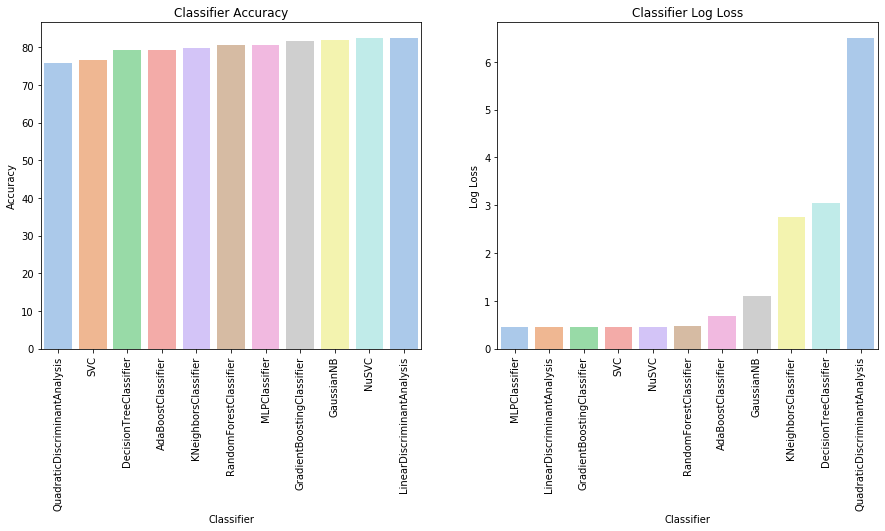

In [20]:
f, ax = plt.subplots(1, 2, figsize=(15,6))

log = log.sort_values(by="Accuracy") 
sns.barplot(x='Classifier', y='Accuracy', data=log, ax=ax[0], palette='pastel')
ax[0].set_title('Classifier Accuracy')
ax[0].tick_params(axis='x', labelrotation=90)

log = log.sort_values(by="Log Loss") 
sns.barplot(x='Classifier', y='Log Loss', data=log, ax=ax[1], palette='pastel')
ax[1].set_title('Classifier Log Loss')
ax[1].tick_params(axis='x', labelrotation=90)

In [21]:
# 第一次采用这个模型
# model = LinearDiscriminantAnalysis()
# model.fit(X_train,y_train)
# result=model.predict(test_data)

In [22]:
# 生成csv文件
# output = pd.DataFrame({'PassengerId': test_data_id, 'Survived':result})
# output.to_csv('myFirstSubmission!.csv', index=False)
# output.shape